In [1]:
#!pip install pandas
#!pip install pydub
#!pip install ffmpeg
#!pip install librosa

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando Bibliotecas *Criar requriments.txt

#import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Configurando matplotlib (Notebook)

%matplotlib inline

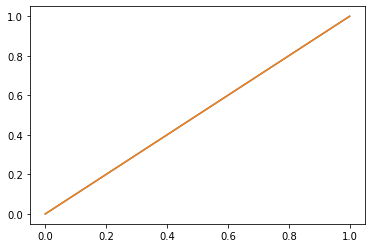

In [5]:
plt.plot([[0, 0], [1, 1]])
plt.show()

In [6]:
file = './sons/Microondas.wav'

In [7]:
# Testando simpleaudio

import simpleaudio as sa

wave_obj = sa.WaveObject.from_wave_file(file)
play_obj = wave_obj.play()
play_obj.wait_done()

In [8]:
# Testando pydub

from pydub import AudioSegment
from pydub.playback import play

sound = AudioSegment.from_wav(file)

sound = sound - 20

play(sound)

In [9]:
type(sound)

pydub.audio_segment.AudioSegment

In [10]:
from IPython.display import Audio

In [11]:
Audio(file)

In [12]:
from librosa import display, load, amplitude_to_db

In [13]:
samples, sampling_rate = load(file, sr=None, mono=True, offset=0.0, duration=None)

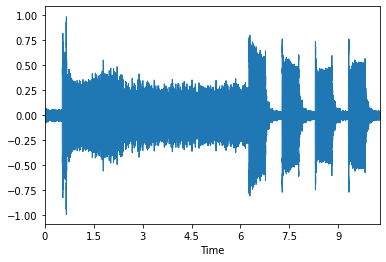

In [14]:
display.waveplot(y=samples, sr=sampling_rate)
plt.show()

In [15]:
len(samples)

452824

In [16]:
sampling_rate

44100

In [17]:
len(samples)/sampling_rate

10.2681179138322

In [19]:
# Testando scipy.io

import scipy.io.wavfile as wavfile

s_rate, signal2 = wavfile.read(file)
print(s_rate, signal2)

44100 [[-272 -266]
 [ 331  326]
 [1201 1195]
 ...
 [ 592  592]
 [ 182  181]
 [ 192  193]]


In [ ]:
type(signal)

In [ ]:
signal[:, 1]

In [ ]:
signal[:, 0]

In [20]:
signal2 = signal2[:, 1]

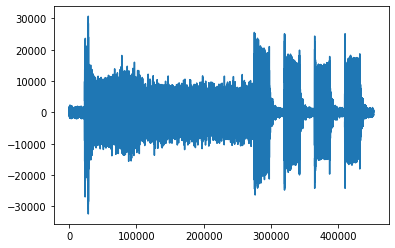

In [22]:
plt.plot(signal2)

In [ ]:
type(signal)

In [ ]:
len(signal)

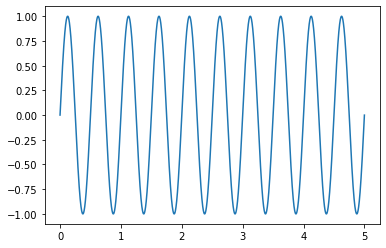

In [3]:
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

In [ ]:
plt.plot(signal)

In [26]:
duration = len(signal2)/s_rate
duration

10.2681179138322

In [27]:
s_rate * duration

452824.0

In [ ]:
from scipy.fft import fft, fftfreq

yf = fft(signal)
xf = fftfreq(int(s_rate * duration), 1 / s_rate)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
from scipy.fft import rfft, rfftfreq

yf = rfft(signal)
xf = rfftfreq(int(s_rate * duration), 1 / s_rate)

plt.figure(figsize=(24, 8), dpi=80)
plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
pd.DataFrame(xf, np.abs(yf)).reset_index().sort_values(by='index', ascending=False).head(10)

In [ ]:
pd.DataFrame(xf, amplitude_to_db(np.abs(yf))).reset_index().sort_values(by='index', ascending=False).head(10)

In [ ]:
len(np.abs(yf))

In [ ]:
win = np.hamming(len(signal))
s_mag = np.abs(yf) * 2 / np.sum(win)

In [ ]:
test = 20 * np.log10(s_mag / 32768) 

In [ ]:
pd.DataFrame(xf, test).reset_index().sort_values(by='index', ascending=False).head(10)

In [ ]:
#https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel

ref = 32768  # 0 dBFS is 32678 with an int16 signal

N = len(signal)
win = np.hamming(N)                                                       
x = signal[0:N] * win                             # Take a slice and multiply by a window
sp = np.fft.rfft(x)                               # Calculate real FFT
s_mag = np.abs(sp) * 2 / np.sum(win)              # Scale the magnitude of FFT by window and factor of 2,
                                                  # because we are using half of FFT spectrum
s_dbfs = 20 * np.log10(s_mag / ref)               # Convert to dBFS
freq = np.arange((N / 2) + 1) / (float(N) / s_rate)   # Frequency axis

plt.plot(freq, s_dbfs)
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.show()

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

segment_size = 512

fs, x = wavfile.read(file)
x = x / 32768.0  # scale signal to [-1.0 .. 1.0]

noverlap = segment_size / 2
f, Pxx = signal.welch(x[:, 0],                        # signal
                      fs=fs,                    # sample rate
                      nperseg=segment_size,     # segment size
                      window='hanning',         # window type to use
                      nfft=segment_size,        # num. of samples in FFT
                      detrend=False,            # remove DC part
                      scaling='spectrum',       # return power spectrum [V^2]
                      )        # overlap between segments

# set 0 dB to energy of sine wave with maximum amplitude
ref = (1/np.sqrt(2)**2)   # simply 0.5 ;)
p = 10 * np.log10(Pxx/ref)

#fill_to = -150 * (np.ones_like(p))  # anything below -150dB is irrelevant
#plt.fill_between(f, p, fill_to )
plt.plot(f, p)
#plt.xlim([f[2], f[-1]])
#plt.ylim([-90, 6])
# plt.xscale('log')   # uncomment if you want log scale on x-axis
plt.xlabel('f, Hz')
plt.ylabel('Power spectrum, dB')
plt.grid(True)
plt.show()

In [ ]:
pd.DataFrame(f, p).reset_index().sort_values(by='index', ascending=False).head(10)

In [ ]:
#https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
b, a = butter_lowpass(1, s_rate)
cutoff = 1000
# Get the filter coefficients so we can check its frequency response.
#= butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
#plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [55]:
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 10      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    print(normal_cutoff)
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(signal2, cutoff, fs, order)

0.6666666666666666


In [69]:
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 0.5      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 5       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    print(normal_cutoff)
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(signal2, cutoff, fs, order)

0.03333333333333333


In [56]:
plt.plot(y)

<IPython.core.display.Javascript object>


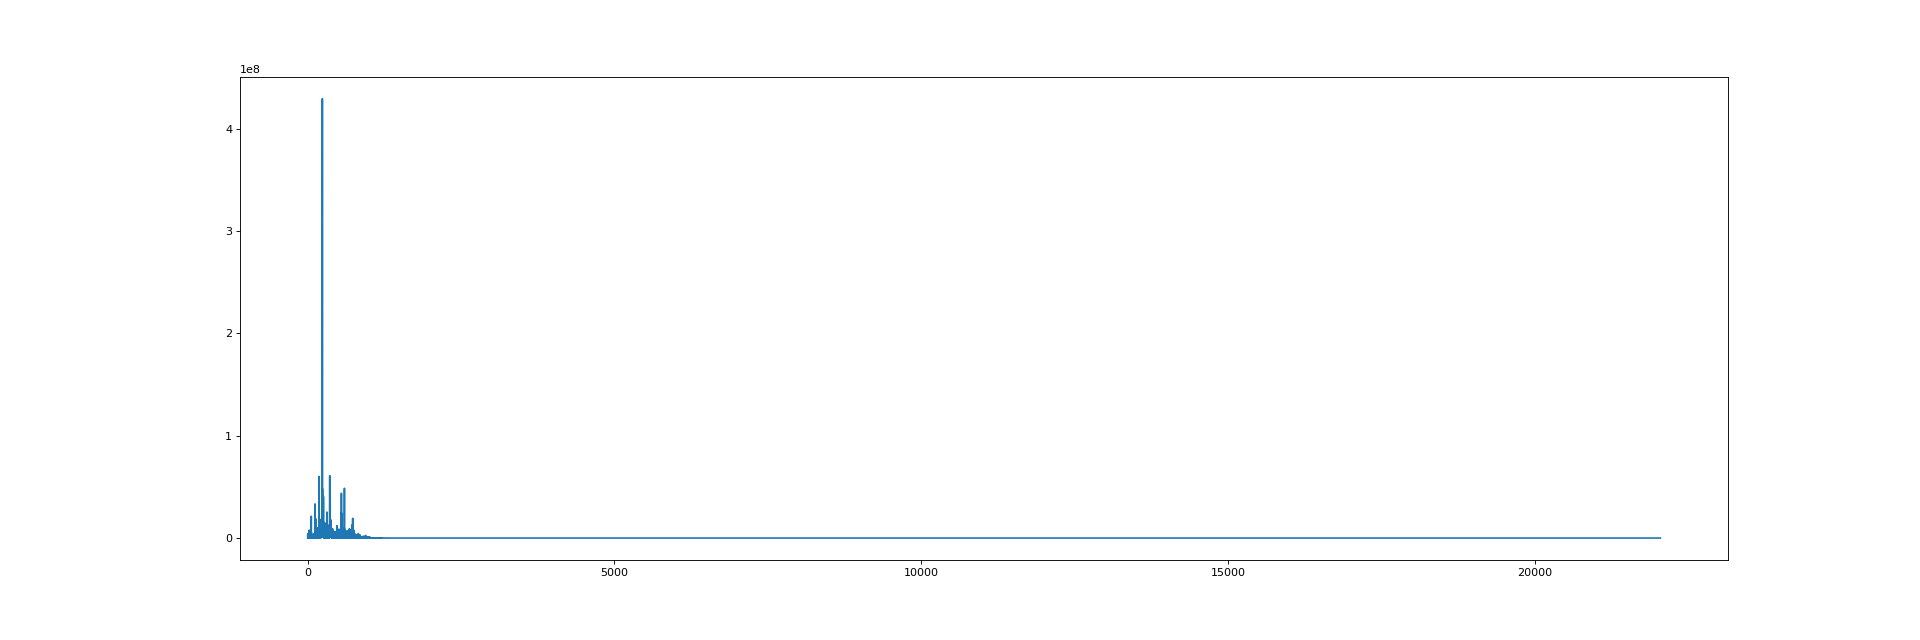

In [70]:
%matplotlib notebook

from scipy.fft import rfft, rfftfreq

yf = rfft(y)
xf = rfftfreq(int(s_rate * duration), 1 / s_rate)

plt.figure(figsize=(24, 8), dpi=80)
plt.plot(xf, np.abs(yf))
plt.show()

In [71]:
# Testando scipy.io

import scipy.io.wavfile as wavfile

wavfile.write('./sons/test.wav', s_rate, y.astype(np.int16))
